In [14]:
import json
# import pandas as pd
from collections import defaultdict
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
import networkx as nx
# from numpy.random import rand, RandomState
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import string
# from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
# import matplotlib
from mpl_toolkits.basemap import Basemap
# import geopy
from sklearn.metrics.pairwise import linear_kernel
from geopy.geocoders import Nominatim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import itertools
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def json_to_dict(filename):
    '''
    INPUT: name of json file
    OUTPUT: dictionary with city keys and description values
    take json file and return dictionary
    '''
    di = {}
    english = []
    with open('wordlist.txt') as f:
        for line in f:
            english.append(line.strip('\r\n'))
            english.append(' ')
    english = set(english)

    with open(filename) as data_file:
        data = json.load(data_file)
        for item in data:
            for key in item.keys():
                unique_text = set(item[key])
                # remove punctuation, make everything lower case
                txt = ''.join(ch.lower() for ch in unique_text if ch not in set(string.punctuation))
                # remove numbers
                txt = ''.join(c for c in txt if c.isdigit() is False)
                # remove the city and country name from its own description
                keyparts = key.split(',')
                txt = ' '.join(c for c in txt.split() if c.lower() != keyparts[0].lower() and c.lower() != keyparts[-1].lower())
                # remove non-english words
                txt = ' '.join(c for c in txt.split() if c in english)
                # populate dictionary
                di[key.strip().strip('\n').encode('ascii', 'ignore')] = txt
    return di

In [4]:
def build_synonym_list(word_list):
    '''
    INPUT: list of words
    OUTPUT: list containing words and all of their synonyms
    take a list of words and return a list containin all synonyms of those words
    '''
    all_synonyms = []
    for word in word_list:
        synonyms = wn.synsets(word.lower())
        for s in synonyms:
            synlist = [l.name() for l in s.lemmas()]
        synlist.append(word.lower())
        all_synonyms.extend([wn.lemmatize(w) for w in synlist])
    return all_synonyms

### Import the data and prepare for tfidf

In [5]:
rs_dict = json_to_dict('../data/ricksteves_articles_blogs_R01.json')
ta_dict = json_to_dict('../data/europe_city_reviews2.json')

empty_count = 0
for k in ta_dict:
    if len(ta_dict[k]) < 100:
        empty_count += 1
# print empty_count

key_list = set(rs_dict.keys() + ta_dict.keys())
europe_dict = dict()
for key in key_list:
    europe_dict[key] = str(rs_dict.get(key)) + str(ta_dict.get(key))
    
# remove cities which contain little or no text
europe_dict = {key: value for key, value in europe_dict.items() if len(value) > 200}
for k in europe_dict:
    if len(europe_dict[k]) < 100:
        print '\n', k
        print europe_dict[k]

# Convert dictionary into dataframe
cities_df = pd.DataFrame.from_dict(europe_dict, orient='index', dtype=None)
cities_df.columns = ['description']

# Extract cities and their descripitions from dataframe
# doc_bodies = cities_df['description']
doc_bodies = cities_df['description'].values
tokenized_corpus = [word_tokenize(content.lower()) for content in doc_bodies]
cities = cities_df.index.values

### Total count and document frequency for nouns, verbs, adverbs, and adjectives

In [5]:
# read each word, assign pos_tag. If pos tag is noun, append dictionary
noun_dict = defaultdict(list)
verb_dict = defaultdict(list)
adj_dict = defaultdict(list)
adv_dict = defaultdict(list)
other_dict = defaultdict(list)

for i, doc in enumerate(tokenized_corpus):
    for word in doc:
        tag = pos_tag([word])[0][1]
        if 'NN' in tag:
            noun_dict[word].append(i)
        if 'JJ' in tag:
            adj_dict[word].append(i)
        if 'VB' in tag:
            verb_dict[word].append(i)
        if 'RB' in tag:
            adv_dict[word].append(i)
        if tag == 'EX' or tag == 'IN' or tag == 'FW' or tag == 'PDT' or tag == 'CD' or tag == 'MD':
            other_dict[word].append(i)
            

### Kmeans Clustering

In [6]:
def kmeans_clustering(doc_bodies, n=12, stpwords=[]):
    '''
    INPUT: corpus, number of clusters, custom stopwords
    OUTPUT: kmeans model and features
    take a document corpus, number of cluster, and custom stopwords and kmeans model to tfidf matrix
    '''
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + stpwords)
    X = vectorizer.fit_transform(doc_bodies)
    features = vectorizer.get_feature_names()
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)

    top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-8:-1]
    print "top features for each cluster:"
    for num, centroid in enumerate(top_centroids):
        print "%d: %s" % (num, ", ".join(features[i] for i in centroid))
    return kmeans, features

In [7]:
def get_cluster_center(word_list):
    wordnet = WordNetLemmatizer()
    word_dict = dict()  # record synonyms and lemmas for each word in a dictionary
    for word in word_list:
        subset = [word]
        for s in wn.synsets(word.lower()):
            synlist = [l.name() for l in s.lemmas()]
            subset.extend([wordnet.lemmatize(w) for w in synlist])
        word_dict[word] = set(subset)
    syns = set([item for sublist in word_dict.values() for item in sublist])

    edge_list = []
    for syn in syns: 
        keys_lst = [key for key, value in word_dict.items() if syn in value]
        if len(keys_lst) > 1:
            edge_list.extend(list(itertools.combinations(keys_lst, 2)))
    G=nx.Graph()
    G.add_edges_from(edge_list)

    max_deg = Counter(nx.degree_centrality(G)).most_common(1)[0][0]
    nbrs = G.neighbors(max_deg)
    return max_deg

In [8]:
def get_word_stats(noun_dict, verb_dict, adj_dict, adv_dict, other_dict, word):
    parts_of_speech = ['noun', 'verb', 'adjective', 'adverb', 'other']
    
    noun_stats = noun_dict.get(word)
    verb_stats = verb_dict.get(word)
    adj_stats = adj_dict.get(word)
    adv_stats = adv_dict.get(word)
    other_stats = other_dict.get(word)
    
    speech_parts = np.array([noun_stats, verb_stats, adj_stats, adv_stats, other_stats])
    
    word_pos = np.argmax(speech_parts)
    
    return parts_of_speech[word_pos], word_pos, len(speech_parts[word_pos]), len(set(speech_parts[word_pos]))

In [9]:
def get_stopwords_count(speech_dicts, word_count, word_pos, greater_than=True):
    vals = speech_dicts[word_pos].values()
    wds = np.array(speech_dicts[word_pos].keys())
    word_counts = np.array([len(val) for val in vals])
    if greater_than:
        return wds[word_counts >= word_count]
    else:
        return wds[word_counts <= word_count]

In [10]:
def get_stopwords(speech_dicts, doc_frequency, word_pos, greater_than=True):
    vals = speech_dicts[word_pos].values()
    wds = np.array(speech_dicts[word_pos].keys())
    doc_freqs = np.array([len(set(val)) for val in vals])
    if greater_than:
        return wds[doc_freqs >= doc_frequency]
    else:
        return wds[doc_freqs <= doc_frequency]

In [ ]:
def calculate_cosine_sim(doc_bodies, check_words, stops):
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + stops)
    
    X = vectorizer.fit_transform(np.append(doc_bodies, check_words))
    cosine_similarities = linear_kernel(X, X)

    return cosine_similarities[-1, :-1]

In [ ]:
def plot_personality_map(m, cosine_similarities, xpts, ypts, citylist):
    plt.figure(figsize=(10, 10))
    cosine_similarities = np.array(cosine_similarities)
    sz = 20. * cosine_similarities / max(cosine_similarities) + 6
    alp = (cosine_similarities / max(cosine_similarities))/1.5 + 0.3
    fs = 15 * cosine_similarities / max(cosine_similarities)

    for i in xrange(len(xpts)):
        plt.plot(xpts[i], ypts[i], '.', markersize=sz[i], color='m', alpha=alp[i])
        plt.text(xpts[i], ypts[i], citylist[i], fontsize=int(fs[i]), alpha=alp[i])

    m.drawcoastlines(linewidth=0.2)
    m.drawcountries(linewidth=0.2)
    # plt.savefig('city_example.png', bbox_inches='tight')
    m.drawmapboundary(fill_color='#1E90FF')
    # fill continents, set lake color same as ocean color.
    m.fillcontinents(color='#F5DEB3',lake_color='#1E90FF')
    plt.show()

In [12]:
# create clusters
kmeans, features = kmeans_clustering(doc_bodies, n=12, stpwords=[])
# kmeans = kmeans_clustering(X,)
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-51:-1]
cluster_cents = []
stp_wds = []
for i, centroid in enumerate(top_centroids):
    cent = get_cluster_center([features[j] for j in centroid])
    pos, word_pos, overallcount, doc_freq = get_word_stats(noun_dict, verb_dict, adj_dict, adv_dict, other_dict, cent)
    print cent, pos, doc_freq
    if doc_freq > 100:
        stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), doc_freq, word_pos))
    


top features for each cluster:
0: introduction, affiliated, swim, head, valuable, water, offered
1: museum, irish, city, dutch, french, andorra, port
2: cave, wildlife, see, speciality, bird, visitor, well
3: nice, place, beautiful, see, great, one, worth
4: great, good, place, well, lovely, staff, visit
5: organic, smell, products, booking, professional, range, clean
6: tower, leaning, baptistery, field, clamber, bell, artistically
7: mosque, dean, dervish, meaning, us, trance, alluring
8: bulgaria, communist, slavic, bulgarian, disclosing, directional, alphabet
9: unpolished, candid, lousy, dimensions, gritty, impromptu, europe
10: walk, cinder, path, along, flat, estuary, views
11: city, one, rick, like, great, people, tour
stars noun 41
go verb 143
take verb 143
get verb 145
get verb 145
feel noun 121
make verb 143
filmed verb 20
learned verb 72
looks noun 112
track noun 44
get verb 145


In [14]:
l = sorted(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 118, 1, greater_than=True))
m = sorted(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 1385, 0, greater_than=True))
mm = sorted(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 5, 1, greater_than=True))

In [15]:
stp_wds = []
# nouns
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 85, 0, greater_than=True))
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 1, 0, greater_than=False))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 1385, 0, greater_than=True))
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 0, greater_than=True))



# verbs
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 86, 1, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 165, 1, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 2, 1, greater_than=False))
# adjectives
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 78, 2, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 925, 2, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 1, 2, greater_than=False))
# adverbs
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 118, 3, greater_than=True))
stp_wds.extend(get_stopwords_count(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 2645, 3, greater_than=True))
# other
stp_wds.extend(get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 0, 4, greater_than=True))
# Two letter words
for lst in tokenized_corpus:
    stp_wds.extend([word for word in lst if len(word) < 3])
# nationality words
stp_wds.extend('''bulgarian,german,germany,portuguese,italy,italian,spain,alcazar,turkey,turkish,polish,poland,scottish,
               bulgaria,french,france,rick,iceland,croatia,spanish,irish,london,norwegian,danish,andersen,swedish,
               elbe,liechtenstein,rome,albanian,swiss,dutch,netherlands,ireland,estonian,latvian,slovenian,soviet,estonia,
               bulgaria,norway,czech,edinburgh,belgian,belgium,romania,bulgaria,finnish'''.split(','))

In [171]:
# import nltk
# nltk.help.upenn_tagset()

In [172]:
# upper = 10
# lower = 1
# up = get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 14, 0, greater_than=False)
# low = get_stopwords(np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict]), 13, 0, greater_than=True)
# print len(up)
# print len(low)
# print len(set(sorted(up)) & set(sorted(low)))
# m = sorted(list(set(up) & set(low)))
# print 'cheerful' in m
# print 'joyful' in m

# print m

### Try snowball and porter stemmers prior to tfidf

In [23]:
snowball = SnowballStemmer('english')
docs_snowball = [' '.join([snowball.stem(word) for word in words.split()]) for words in doc_bodies]

In [36]:
dict_snowball = defaultdict(list)
# for each word, check if adjective. if adjective, add original word to dictionary list
for words in doc_bodies:
    for word in words.split():
        if 'JJ' in pos_tag([word])[0][1]:
            dict_snowball[snowball.stem(word)].append(word)

### Generate stop words

In [103]:
stopwds = []
for words in docs_snowball:
    for word in words.split():
        if len(dict_snowball[word]) < 1:
            stopwds.append(word)

            pos_dicts = np.array([noun_dict, verb_dict, adj_dict, adv_dict, other_dict])           
stopwds.extend([snowball.stem(word) for word in get_stopwords(pos_dicts, 78, 2, greater_than=True)])
stopwds.extend([snowball.stem(word) for word in get_stopwords_count(pos_dicts, 925, 2, greater_than=True)])
stopwds.extend([snowball.stem(word) for word in get_stopwords_count(pos_dicts, 1, 2, greater_than=False)])

removelist = '''swedish,french,polish,swiss,italian,likely,finnish,german,norwegian,portuguese,american,spanish,\
scottish,russian,belgian,irish,actual,tuscan,arrive,vatican,affected,especial,british,nordic,flemish,venetian,\
soviet,golden,unknown,possible,detailed,useful,vertical,alphabetical,noteworthy,basic,valuable,slovenian,manageable,\
experienced,particular,numbered,essential,final,estuary,weekly,regular,flat,related,continuous,continued,mixed,\
estonian,advisable,characteristic,satisfied,black,prepared,baltic,similar,georgian'''.split(',')
stopwds.extend([snowball.stem(word) for word in removelist])
print len(set(stopwds))

9853


In [104]:
kmeans, features = kmeans_clustering(docs_snowball, n=12, stpwords=list(set(stopwds)))
# kmeans = kmeans_clustering(X,)
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-8:-1]
cluster_cents = []
print '\n'
for i, centroid in enumerate(top_centroids):
    wordlist = []

    for j in centroid:
        wordlist.extend(list(set(dict_snowball[features[j]])))
    print ', '.join(wordlist)

top features for each cluster:
0: inform, art, option, natur, incred, person, music
1: art, architectur, inform, access, attract, certain, probabl
2: inform, thought, attract, atmospher, access, person, art
3: art, cultur, rich, civil, black, pedestrian, music
4: urban, oblivi, general, cost, contagi, inflat, competit
5: sculptur, photograph, art, attent, educ, funerari, inform
6: cost, bigger, marvel, tini, current, classic, thought
7: imagin, safe, inspir, strong, thought, music, delight
8: nervous, pleas, apprehens, fabul, etern, oldest, adventur
9: mysteri, mystic, ritual, conserv, pompous, ey, overdu
10: profession, product, organ, zoolog, floral, fortuit, formid
11: art, cultur, unpolish, nake, dramat, rich, sculptur


informal, informative, artful, optional, natural, incredible, personal, personable, musical
artful, architectural, informal, informative, accessible, attractive, certain, probable
informal, informative, thoughtful, attractive, atmospheric, accessible, personal, per

(168, 14686)
(168, 168)
167
Bern, Switzerland set(['easygoing', 'carefree'])
Woking, England set(['calming', 'sedate', 'relaxing', 'relax', 'relaxed', 'quiet', 'rest', 'comfortable', 'calm', 'easy', 'peaceful', 'tranquil'])
Dusseldorf, Germany set(['serene', 'relaxing', 'relax', 'relaxed', 'quiet', 'rest', 'comfortable', 'calm', 'easy', 'peaceful', 'soothing'])
Zagreb, Croatia set(['calming', 'easygoing', 'relaxing', 'relax', 'relaxed', 'quiet', 'rest', 'comfortable', 'serenity', 'easy', 'peaceful', 'sedate'])
Slough, England set(['relaxing', 'relax', 'peaceful', 'quiet', 'rest', 'relaxation', 'tranquil'])


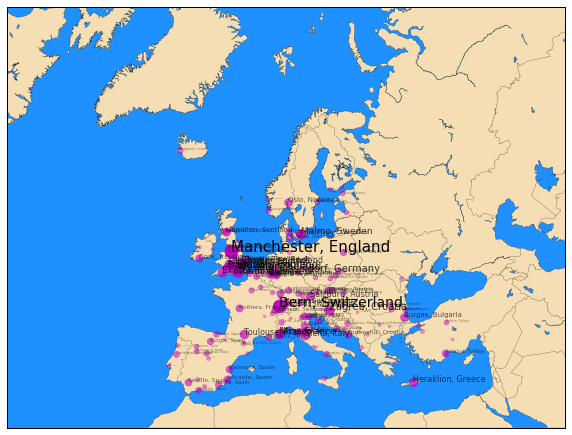

(168, 14691)
(168, 168)
167
Bury, England set(['enjoy', 'delight', 'enjoyable', 'amused', 'engaging', 'delightful', 'amusing', 'fun', 'pleasant'])
Reading, England set(['enjoy', 'enjoyable', 'recreational', 'engaging', 'amusing', 'fun', 'entertaining', 'pleasant'])
Malaga, Spain set(['enjoy', 'pleasant', 'recreational', 'enjoyable', 'delightful', 'amusing', 'fun', 'entertaining'])
Woking, England set(['enjoy', 'pleasant', 'enjoyable', 'amusing', 'fun', 'pleasurable'])
Leicester, England set(['enjoy', 'pleasant', 'festive', 'enjoyable', 'delightful', 'lively', 'fun', 'entertaining', 'amusing'])


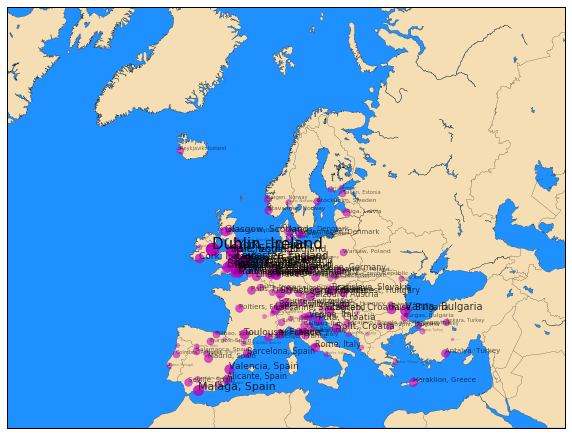

(168, 14694)
(168, 168)
167
Krakow, Poland set(['interesting', 'intellectual', 'cultural', 'deep', 'learning', 'education'])
Bristol, England set(['educational', 'mental', 'interesting', 'study', 'studied', 'educate', 'informative', 'school', 'learning', 'learn', 'highbrow', 'intelligent'])
Aarhus, Denmark set(['educational', 'mental', 'instructive', 'interesting', 'study', 'studied', 'school', 'intellectual', 'cultural', 'learning', 'learn', 'learned', 'education'])
Rome, Italy set(['educational', 'wise', 'school', 'interesting', 'study', 'cultural', 'deep', 'wisdom', 'thoughtful', 'intellectual', 'learn', 'mentally', 'learned', 'education', 'smart', 'scholar'])
Cologne, Germany set(['wise', 'mental', 'interesting', 'study', 'deep', 'informative', 'cultural', 'learning', 'learn', 'learned', 'scholar'])


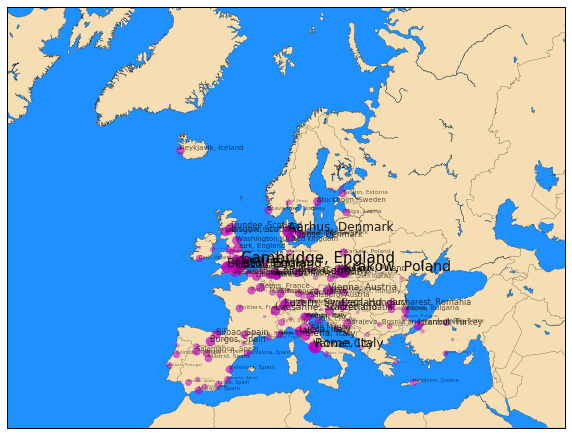

(168, 14695)
(168, 168)
167
Olomouc, Czech Republic set(['spiritual', 'religious', 'inspired', 'holy', 'church'])
Zamora, Spain set(['god', 'inspired', 'religious', 'inspire', 'church'])
Krakow, Poland set(['blessing', 'sacred', 'church'])
Cologne, Germany set(['theology', 'religious', 'holy', 'sacred', 'church'])
Linz, Austria set(['god', 'ecclesiastic', 'church'])


In [ ]:
with open('personalities.txt') as f:
    for line in f:
        personality = line.strip('\n').split(', ') # read words on each line of file
        cosine_similarities = calculate_cosine_sim(doc_bodies, ' '.join(personality), [])
        print len(cosine_similarities)
        top5 = np.argsort(cosine_similarities)[::-1][:5]
        for num in top5:
            print cities[num], set(personality) & set(tokenized_corpus[num])
        geolocator = Nominatim()
        xpts = []
        ypts = []
        ctlst = []
        sim = []
        for i, city in enumerate(cities):
            location = geolocator.geocode(city, timeout=10)
            if location is not None:
                xpt, ypt = m(location.longitude, location.latitude)
                sim.append(cosine_similarities[i])
                ctlst.append(city)
                xpts.append(xpt)
                ypts.append(ypt)
            else:
                print city
        plot_personality_map(m, sim, xpts, ypts, ctlst)

In [12]:
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')

geolocator = Nominatim()
xpts = []
ypts = []
ctlst = []
sim = []
for i, city in enumerate(cities):
    location = geolocator.geocode(city, timeout=10)
    if location is not None:
        xpt, ypt = m(location.longitude, location.latitude)
        sim.append(cosine_similarities[i])
        ctlst.append(city)
        xpts.append(xpt)
        ypts.append(ypt)

In [ ]:
print max(cosine_similarities)

In [ ]:
plot_personality_map(m, sim, xpts, ypts, ctlst)